# Advanced_Stock_Price_Prediction

This notebook implements and compares two sequential models for stock price prediction using PyTorch, as per the assignment instructions.

**Models:**
1.  **Model 1:** A standard LSTM (Long Short-Term Memory) network.
2.  **Model 2:** An LSTM network enhanced with an attention mechanism.

**Objective:**
Predict the *relative change* (log returns) of a stock's price and evaluate the models' performance using autoregressive prediction.

## 0. Setup and Imports

First, we import all necessary libraries and set up our environment, including the device (GPU if available) and key parameters.

In [1]:
import os
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import time

# Set device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# Create a 'models' directory if it doesn't already exist
os.makedirs("models", exist_ok=True)

# --- Configuration Parameters ---
STOCK_TICKER = "^GSPC"      # S&P 500 Index
START_DATE = "2014-01-01"   # 10 years of data
END_DATE = "2024-11-01"     # Today's date or recent

TRAIN_SPLIT = 0.85          # 85% for training
BASE_WINDOW_SIZE = 50       # Initial window size (50 days)

# --- Model Hyperparameters ---
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 100                # Max epochs (will use early stopping)
HIDDEN_SIZE = 64
NUM_LAYERS = 2
DROPOUT = 0.2
PATIENCE = 10               # For early stopping
EPOCHS_ATTENTION = 100
LEARNING_RATE_ATTENTION = 0.0001
PATIENCE_ATTENTION = 10

Using device: cuda


## 1. Data Acquisition

We use the `yfinance` package to download the daily stock price data for our chosen ticker.

[*********************100%***********************]  1 of 1 completed


<Figure size 1400x700 with 0 Axes>

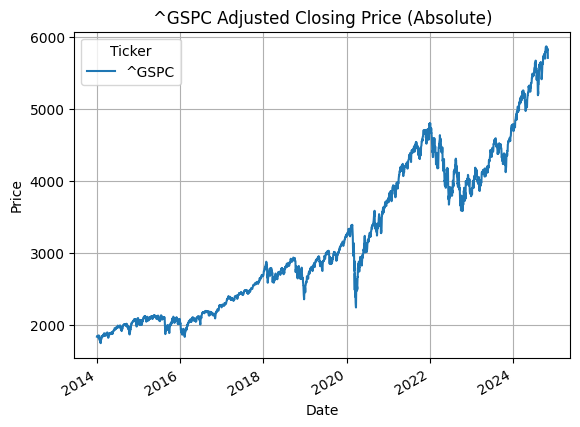

In [2]:
try:
    # Download data
    data = yf.download(STOCK_TICKER, start=START_DATE, end=END_DATE, auto_adjust=False)
    
    if data.empty:
        print(f"No data found for ticker {STOCK_TICKER}.")
    else:
        # Now 'Adj Close' and 'Volume' are guaranteed to be there
        prices_df = data[['Adj Close', 'Volume']]
        
        # Plot the 'Adj Close' price
        plt.figure(figsize=(14, 7))
        prices_df['Adj Close'].plot()
        plt.title(f"{STOCK_TICKER} Adjusted Closing Price (Absolute)")
        plt.ylabel("Price")
        plt.xlabel("Date")
        plt.grid(True)
        plt.show()

except Exception as e:
    print(f"Error downloading data: {e}")

## 2. Data Preparation

### 2.1. Calculate Relative Values (Log Returns)

As instructed, we will predict relative values instead of absolute prices. We'll use **log returns**, which are defined as $\log(P_t / P_{t-1})$. This transformation stabilizes the variance and makes the time series more stationary.


### 2.2. Create Sliding Window Dataset

We implement a function to create our dataset based on the sliding window approach.
-   **Input (X):** A sequence of `window_size` consecutive log returns.
-   **Target (y):** The *next* log return immediately following the input sequence.

In [3]:
from sklearn.preprocessing import StandardScaler

# --- 1. Define Sliding Window Function (Same as before) ---
def create_sliding_windows(data, window_size):
    """
    Creates sliding window sequences (X) and corresponding targets (y).
    Input `data` is expected to be a 2D NumPy array (N, num_features).
    The target `y` will be the *first feature* (log_return) at the next time step.
    """
    X, y = [], []
    for i in range(data.shape[0] - window_size):
        # Input sequence: (window_size, num_features)
        X.append(data[i : i + window_size, :])
        
        # Target value: (1,) - just the log return
        # Since `data` is scaled, this `y` is ALSO scaled.
        y.append(data[i + window_size, 0]) 
        
    return np.array(X), np.array(y)

# --- 2. Calculate Features ---

# Feature 1: Log Returns for 'Adj Close'
log_returns = np.log(prices_df['Adj Close'] / prices_df['Adj Close'].shift(1)).squeeze("columns")

# Feature 2: Log of Volume (add 1 to prevent log(0) errors)
log_volume = np.log(prices_df['Volume'] + 1).squeeze("columns")

# Combine into a new DataFrame
features_df = pd.DataFrame({
    'log_returns': log_returns,
    'log_volume': log_volume
})

# Drop the first row with NaN
features_df = features_df.dropna()

# *** IMPORTANT: Save the unscaled log returns (as a pd.Series) for reconstruction ***
log_returns_unscaled_pd = features_df['log_returns']

# Convert features to a NumPy array (N, 2)
features_np = features_df.values.astype(np.float32)

# --- 3. Split the Data ---
split_idx_raw = int(len(features_np) * TRAIN_SPLIT)
train_data_raw = features_np[:split_idx_raw]
test_data_raw = features_np[split_idx_raw:]

# --- 4. Scale the Data ---
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data_raw)
test_data_scaled = scaler.transform(test_data_raw)

# --- 5. Extract Scaling Params for y ---
# We still need these for un-scaling predictions later
log_return_scale = scaler.scale_[0]
log_return_mean = scaler.mean_[0]

# --- 6. Create Sliding Windows ---
# X will be (N, window_size, 2)
# y_train and y_test are ALREADY SCALED because they come from train_data_scaled
X_train, y_train = create_sliding_windows(train_data_scaled, BASE_WINDOW_SIZE)
X_test, y_test = create_sliding_windows(test_data_scaled, BASE_WINDOW_SIZE)

# --- 7. Reshape y ---
# (The buggy manual scaling section is now REMOVED)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print(f"Training set: X shape {X_train.shape}, y shape {y_train.shape}")
print(f"Test set:     X shape {X_test.shape}, y shape {y_test.shape}")

# --- 8. Convert to Tensors ---
X_train_t = torch.tensor(X_train).float()
y_train_t = torch.tensor(y_train).float()
X_test_t = torch.tensor(X_test).float()
y_test_t = torch.tensor(y_test).float()

print(f"\nTensor shapes: {X_train_t.shape}")

# --- 9. Create DataLoaders ---
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataset = TensorDataset(X_test_t, y_test_t)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Training set: X shape (2267, 50, 2), y shape (2267, 1)
Test set:     X shape (359, 50, 2), y shape (359, 1)

Tensor shapes: torch.Size([2267, 50, 2])


## 3. Model Implementation

### Model 1: LSTM Only

This is a standard LSTM model. It consists of an `nn.LSTM` layer followed by an `nn.Linear` layer to produce the final prediction.

**Architecture:**
1.  Input `x` (batch, seq_len, 1) goes into the LSTM.
2.  The LSTM outputs hidden states for all time steps.
3.  We take the output from the *very last time step* (`lstm_out[:, -1, :]`).
4.  This final hidden state is passed to a Linear layer to predict a single value.

In [4]:
# --- Model 1: LSTM Only ---
class LSTMModel(nn.Module):
    def __init__(self, input_size=2, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, output_size=1, dropout=DROPOUT):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # x shape is (batch, seq_len, 2)
        lstm_out, _ = self.lstm(x)
        last_time_step_out = lstm_out[:, -1, :]
        prediction = self.fc(last_time_step_out)
        return prediction

### Model 2: LSTM with Attention

This model adds an attention mechanism to the LSTM. Instead of just using the *last* hidden state, the attention mechanism learns to assign different "importance" weights to the hidden states from *all* time steps. It then computes a weighted sum (the "context vector") of all hidden states, which is used for the final prediction.

**Architecture:**
1.  Input `x` goes into the LSTM, producing all hidden states `lstm_out` (batch, seq_len, hidden_size).
2.  **Attention Calculation:**
    a.  Pass `lstm_out` through a linear layer and `tanh` activation to get "energy" scores.
    b.  Pass the energy scores through another linear layer to get raw scores (batch, seq_len, 1).
    c.  Apply `softmax` along the time dimension to get attention weights (batch, seq_len, 1). These weights sum to 1.
3.  **Context Vector:**
    a.  Multiply the weights with the original `lstm_out` (element-wise).
    b.  Sum the results across the time dimension to get a single context vector (batch, hidden_size).
4.  Pass this context vector to the final Linear layer for prediction.

In [5]:
# --- Model 2: LSTM + Attention ---
class LSTMAttentionModel(nn.Module):
    def __init__(self, input_size=2, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, output_size=1, dropout=DROPOUT):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size, 
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout
        )
        
        # Keep the LayerNorm fix
        self.layer_norm = nn.LayerNorm(hidden_size) 
        self.attn_W = nn.Linear(hidden_size, hidden_size)
        self.attn_v = nn.Linear(hidden_size, 1, bias=False)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape is (batch, seq_len, 2)
        lstm_out, _ = self.lstm(x)
        lstm_out_norm = self.layer_norm(lstm_out) 
        
        energy = torch.tanh(self.attn_W(lstm_out_norm))
        scores = self.attn_v(energy)
        weights = torch.softmax(scores, dim=1)
        weighted_out = weights * lstm_out_norm
        context = torch.sum(weighted_out, dim=1)
        
        prediction = self.fc(context)
        return prediction

## 4. Training the Models


### 4.1. Early Stopping Utility

To prevent overfitting and save time, we'll implement an `EarlyStopping` class. It monitors the validation loss and stops training if it doesn't improve for a specified number of `patience` epochs. It also saves the best model.

In [6]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0, verbose=True, path='checkpoint.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.path = path
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            if self.verbose:
                print(f"   ...Val loss improved to {val_loss:.6f}. Saving model to {self.path}...")
            torch.save(model.state_dict(), self.path)
        else:
            self.counter += 1
            if self.verbose:
                print(f"   ...EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True


### 4.2. Training Function

This function contains the main training and validation loop. It's reusable for both models.

In [7]:
def train_model(model, train_loader, test_loader, epochs, lr, patience, model_path):
    criterion = nn.MSELoss()  # Mean Squared Error is suitable for regression
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    early_stopper = EarlyStopping(patience=patience, path=model_path, verbose=True)
    
    train_losses = []
    val_losses = []
    
    model.to(DEVICE)
    
    print(f"--- Starting Training for {model_path} ---")
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_train_loss = 0.0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            # Clip gradients to prevent exploding
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            running_train_loss += loss.item() * X_batch.size(0)
        
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        # --- Validation ---
        model.eval()  # Set model to evaluation mode
        running_val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                running_val_loss += loss.item() * X_batch.size(0)
                
        epoch_val_loss = running_val_loss / len(test_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        print(f"Epoch {epoch+1:03}/{epochs:03} | Train Loss: {epoch_train_loss:.6f} | Val Loss: {epoch_val_loss:.6f}")
        
        # Check early stopping
        early_stopper(epoch_val_loss, model)
        if early_stopper.early_stop:
            print("Early stopping triggered!")
            break
            
    end_time = time.time()
    print(f"--- Training Finished in {end_time - start_time:.2f}s ---")
    
    # Load the best model state
    model.load_state_dict(torch.load(model_path))
    
    return model, train_losses, val_losses

def plot_losses(train_losses, val_losses, title):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.grid(True)
    plt.show()

### 4.3. Train Model 1 (LSTM)

--- Starting Training for models/best_lstm_model.pth ---
Epoch 001/100 | Train Loss: 1.012700 | Val Loss: 0.448124
   ...Val loss improved to 0.448124. Saving model to models/best_lstm_model.pth...
Epoch 002/100 | Train Loss: 1.010790 | Val Loss: 0.446143
   ...Val loss improved to 0.446143. Saving model to models/best_lstm_model.pth...
Epoch 003/100 | Train Loss: 1.008754 | Val Loss: 0.446055
   ...Val loss improved to 0.446055. Saving model to models/best_lstm_model.pth...
Epoch 004/100 | Train Loss: 1.005409 | Val Loss: 0.447728
   ...EarlyStopping counter: 1 out of 10
Epoch 005/100 | Train Loss: 0.997931 | Val Loss: 0.445315
   ...Val loss improved to 0.445315. Saving model to models/best_lstm_model.pth...
Epoch 006/100 | Train Loss: 0.989978 | Val Loss: 0.447230
   ...EarlyStopping counter: 1 out of 10
Epoch 007/100 | Train Loss: 0.985793 | Val Loss: 0.448190
   ...EarlyStopping counter: 2 out of 10
Epoch 008/100 | Train Loss: 0.984476 | Val Loss: 0.443425
   ...Val loss improved 

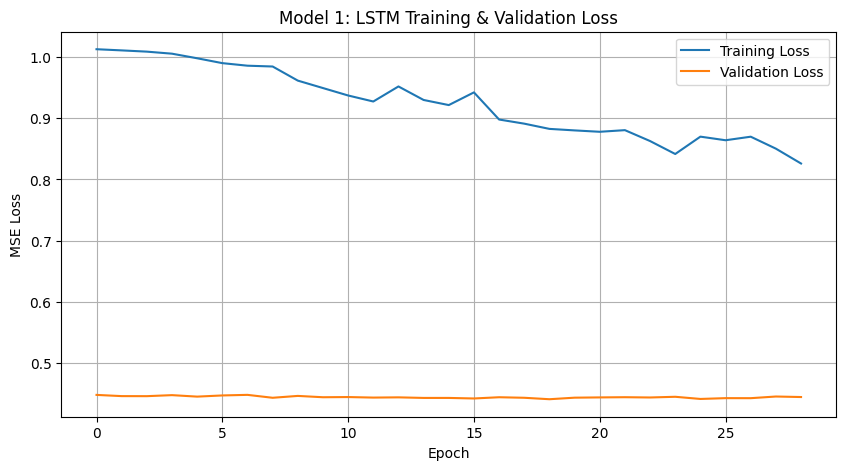

In [8]:
lstm_model = LSTMModel(
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(DEVICE)

lstm_model, lstm_train_loss, lstm_val_loss = train_model(
    lstm_model,
    train_loader,
    test_loader,
    EPOCHS,
    LEARNING_RATE,
    PATIENCE,
    'models/best_lstm_model.pth' # Path to save best model
)

plot_losses(lstm_train_loss, lstm_val_loss, "Model 1: LSTM Training & Validation Loss")

### 4.4. Train Model 2 (LSTM + Attention)

We train the attention model under the same conditions (same data, epochs, lr, etc.) for a fair comparison.

--- Starting Training for models/best_attention_model.pth ---
Epoch 001/100 | Train Loss: 1.015180 | Val Loss: 0.479455
   ...Val loss improved to 0.479455. Saving model to models/best_attention_model.pth...
Epoch 002/100 | Train Loss: 1.015966 | Val Loss: 0.450546
   ...Val loss improved to 0.450546. Saving model to models/best_attention_model.pth...
Epoch 003/100 | Train Loss: 1.012410 | Val Loss: 0.452236
   ...EarlyStopping counter: 1 out of 10
Epoch 004/100 | Train Loss: 1.012115 | Val Loss: 0.450196
   ...Val loss improved to 0.450196. Saving model to models/best_attention_model.pth...
Epoch 005/100 | Train Loss: 1.011299 | Val Loss: 0.453540
   ...EarlyStopping counter: 1 out of 10
Epoch 006/100 | Train Loss: 1.012515 | Val Loss: 0.452009
   ...EarlyStopping counter: 2 out of 10
Epoch 007/100 | Train Loss: 1.011486 | Val Loss: 0.455046
   ...EarlyStopping counter: 3 out of 10
Epoch 008/100 | Train Loss: 1.012922 | Val Loss: 0.451093
   ...EarlyStopping counter: 4 out of 10
Epoch

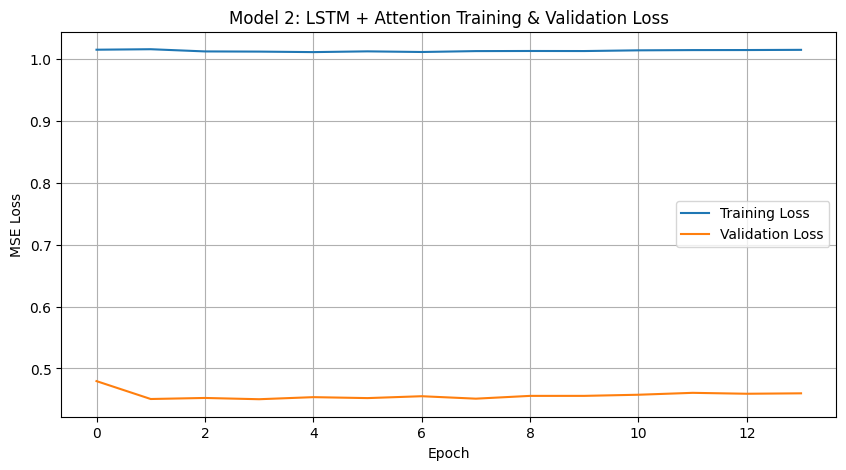

In [9]:
attention_model = LSTMAttentionModel(
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(DEVICE)

attention_model, attn_train_loss, attn_val_loss = train_model(
    attention_model,
    train_loader,
    test_loader,
    EPOCHS_ATTENTION,
    LEARNING_RATE_ATTENTION,
    PATIENCE_ATTENTION,
    'models/best_attention_model.pth' # Path to save best model
)

plot_losses(attn_train_loss, attn_val_loss, "Model 2: LSTM + Attention Training & Validation Loss")

## 5. Evaluation and Comparison

### 5.1. Autoregressive Prediction

This is the most critical part of the evaluation. We will simulate a real-world prediction scenario:
1.  Take the **first window** from the test set (`X_test_t[0]`) as the initial input.
2.  Predict the next value (Prediction 1).
3.  Create a **new window** by *dropping* the first value of the initial window and *appending* Prediction 1 to the end.
4.  Use this new window to predict the next value (Prediction 2).
5.  Repeat this process for the entire length of the test set.

This method tests the model's stability, as prediction errors will accumulate (compound) over time.

In [10]:
def autoregressive_predict(model, initial_window_tensor, n_predictions):
    """
    Performs autoregressive prediction for a multivariate (2-feature) model.
    `initial_window_tensor` should have shape (window_size, 2).
    """
    model.eval()
    predictions = []
    
    # current_window shape: (window_size, 2)
    current_window = initial_window_tensor.clone().to(DEVICE)
    
    with torch.no_grad():
        for _ in range(n_predictions):
            # input_tensor shape: (1, window_size, 2)
            input_tensor = current_window.unsqueeze(0)
            
            # Get prediction (pred shape will be (1, 1))
            pred = model(input_tensor)
            
            # Store the prediction (as a simple number)
            predictions.append(pred.item())
            
            
            # We need to build a new 2-feature entry.
            # Feature 1 is our prediction (shape (1, 1))
            # Feature 2 is the last log_volume from the current window
            # current_window[-1, 1] gets the last vol, reshape to (1, 1)
            last_log_volume = current_window[-1, 1].reshape(1, 1)
            
            # Combine them into a 2-feature tensor: (1, 2)
            new_entry_tensor = torch.cat((pred, last_log_volume), dim=1)
            
            # Now concatenate the (window_size-1, 2) tensor with the new (1, 2) tensor
            current_window = torch.cat((current_window[1:], new_entry_tensor), dim=0)
            
    return np.array(predictions)

# Get the first window from the test set
# X_test_t shape is (N_test, window_size, 1). We need the first item.
first_test_window = X_test_t[0]

# Number of predictions to make == length of the test set
n_test_predictions = len(y_test_t)

print("Running autoregressive predictions for LSTM model...")
lstm_preds_autoregressive = autoregressive_predict(lstm_model, first_test_window, n_test_predictions)

print("Running autoregressive predictions for Attention model...")
attn_preds_autoregressive = autoregressive_predict(attention_model, first_test_window, n_test_predictions)

# Get actual values for comparison
actuals = y_test_t.cpu().numpy().flatten()

print("Predictions complete.")

Running autoregressive predictions for LSTM model...
Running autoregressive predictions for Attention model...
Predictions complete.


### 5.2. Metrics

We'll use common regression metrics to compare the models:
-   **MSE (Mean Squared Error):** Penalizes large errors heavily.
-   **RMSE (Root Mean Squared Error):** MSE in the original units (log returns).
-   **MAE (Mean Absolute Error):** Average absolute error.

In [11]:
def calculate_metrics(preds, actuals):
    mse = mean_squared_error(actuals, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, preds)
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae}

lstm_metrics = calculate_metrics(lstm_preds_autoregressive, actuals)
attn_metrics = calculate_metrics(attn_preds_autoregressive, actuals)

print("--- Autoregressive Performance Metrics ---")
metrics_df = pd.DataFrame([lstm_metrics, attn_metrics], index=['LSTM Model', 'Attention Model'])
display(metrics_df)

--- Autoregressive Performance Metrics ---


,MSE,RMSE,MAE
LSTM Model,0.441517,0.664468,0.506667
Attention Model,0.446544,0.668239,0.511825


### 5.3. Visualization: Predicted vs. Actual Relative Changes

Let's plot the predicted log returns against the actual log returns. Due to the compounding error of autoregression, we expect the predictions to drift over time.

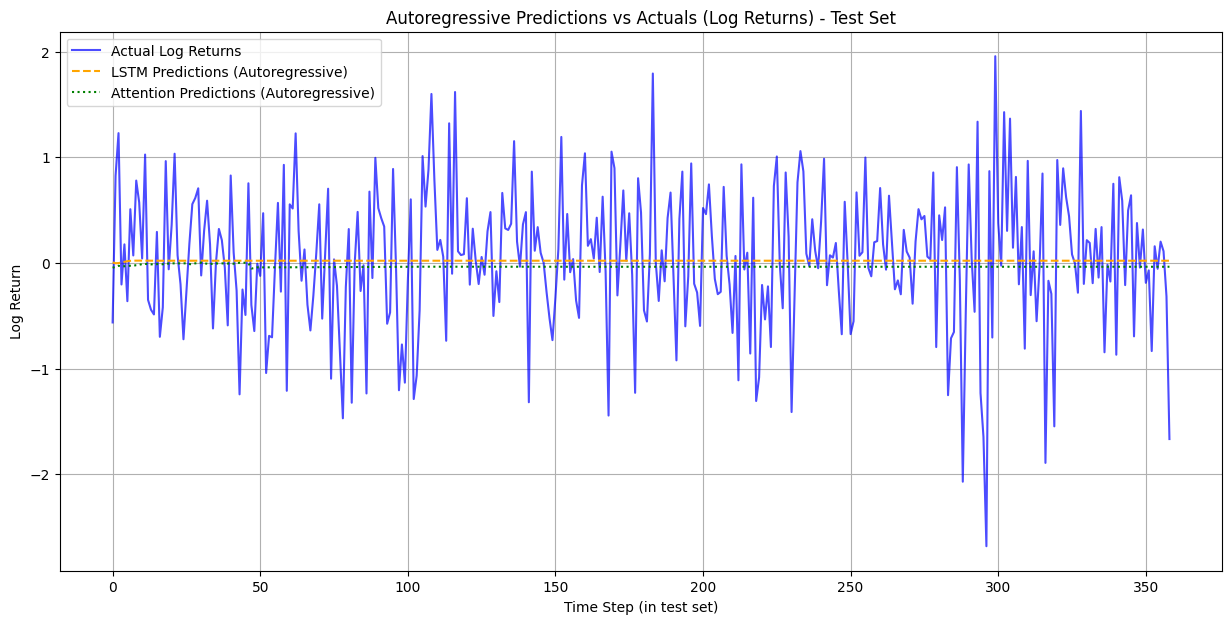

In [12]:
plt.figure(figsize=(15, 7))
plt.plot(actuals, label='Actual Log Returns', color='blue', alpha=0.7)
plt.plot(lstm_preds_autoregressive, label='LSTM Predictions (Autoregressive)', color='orange', linestyle='--')
plt.plot(attn_preds_autoregressive, label='Attention Predictions (Autoregressive)', color='green', linestyle=':')
plt.legend()
plt.title(f'Autoregressive Predictions vs Actuals (Log Returns) - Test Set')
plt.xlabel('Time Step (in test set)')
plt.ylabel('Log Return')
plt.grid(True)
plt.show()

# One-Step-Ahead Prediction (For a fair model comparison)


Running ONE-STEP-AHEAD (NON-AUTOREGRESSIVE) predictions...
One-step-ahead predictions complete.


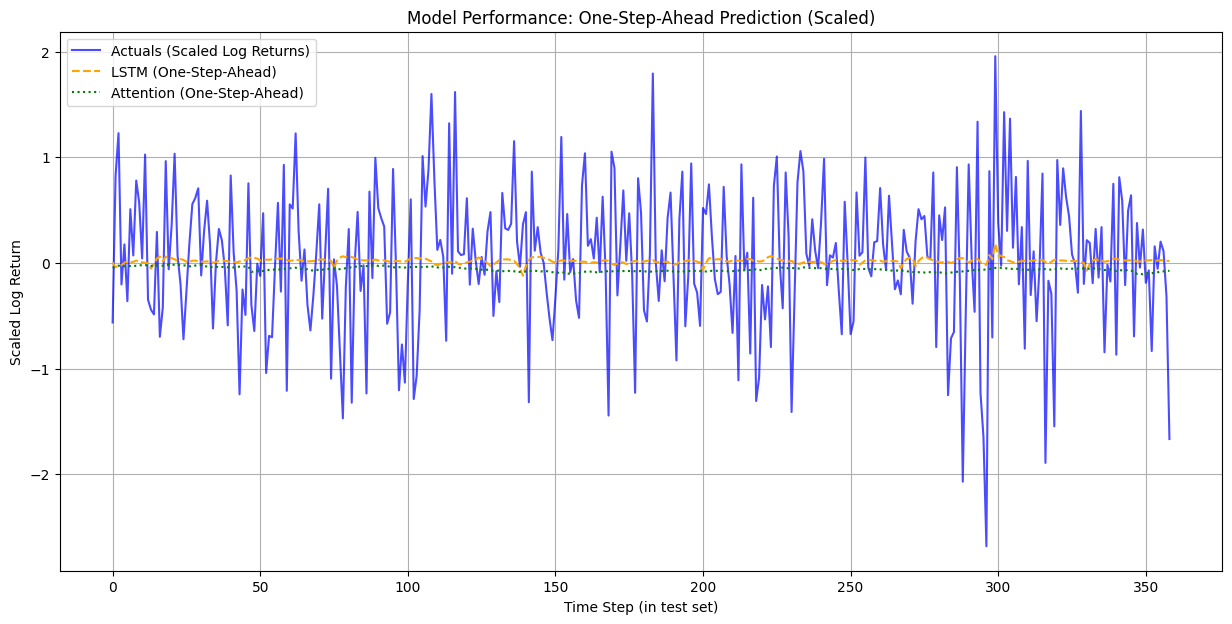


--- One-Step-Ahead Performance Metrics (Scaled) ---


,MSE,RMSE,MAE
LSTM (One-Step),0.441065,0.664127,0.508203
Attention (One-Step),0.450196,0.670966,0.515925


In [13]:
def get_one_step_ahead_predictions(model, data_loader): # <-- Takes data_loader as argument
    """
    Performs a non-autoregressive (one-step-ahead) prediction 
    on the entire test set using the provided DataLoader.
    """
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for X_batch, y_batch in data_loader:     
            X_batch = X_batch.to(DEVICE)
            batch_preds = model(X_batch)
            predictions.extend(batch_preds.cpu().numpy().flatten())
            
    return np.array(predictions)

print("\nRunning ONE-STEP-AHEAD (NON-AUTOREGRESSIVE) predictions...")

# Get one-step-ahead predictions using the MAIN test_loader
lstm_preds_one_step = get_one_step_ahead_predictions(lstm_model, test_loader)
attn_preds_one_step = get_one_step_ahead_predictions(attention_model, test_loader)

# Get the SCALED actuals for this plot
actuals_scaled = y_test_t.cpu().numpy().flatten()

print("One-step-ahead predictions complete.")

# --- Visualize the One-Step-Ahead predictions ---
plt.figure(figsize=(15, 7))
plt.plot(actuals_scaled, label='Actuals (Scaled Log Returns)', color='blue', alpha=0.7)
plt.plot(lstm_preds_one_step, label='LSTM (One-Step-Ahead)', color='orange', linestyle='--')
plt.plot(attn_preds_one_step, label='Attention (One-Step-Ahead)', color='green', linestyle=':')
plt.legend()
plt.title('Model Performance: One-Step-Ahead Prediction (Scaled)')
plt.xlabel('Time Step (in test set)')
plt.ylabel('Scaled Log Return')
plt.grid(True)
plt.show()

# --- Calculate Metrics for this test ---
print("\n--- One-Step-Ahead Performance Metrics (Scaled) ---")
lstm_metrics_one_step = calculate_metrics(lstm_preds_one_step, actuals_scaled)
attn_metrics_one_step = calculate_metrics(attn_preds_one_step, actuals_scaled)

one_step_metrics_df = pd.DataFrame([lstm_metrics_one_step, attn_metrics_one_step], 
                                   index=['LSTM (One-Step)', 'Attention (One-Step)'])
display(one_step_metrics_df)

### 5.4. Visualization: Reconstructed Absolute Prices

To make the results more intuitive, we will reconstruct the absolute prices from the predicted log returns.

The formula is: $P_t = P_{t-1} \cdot e^{\text{log\_return}_t}$

We need a starting price, which will be the last *actual* price *before* the test set began.

Reconstruction Start Price (on 2023-05-30): $4205.52
Actual test prices to compare: 359
Predictions made: 359


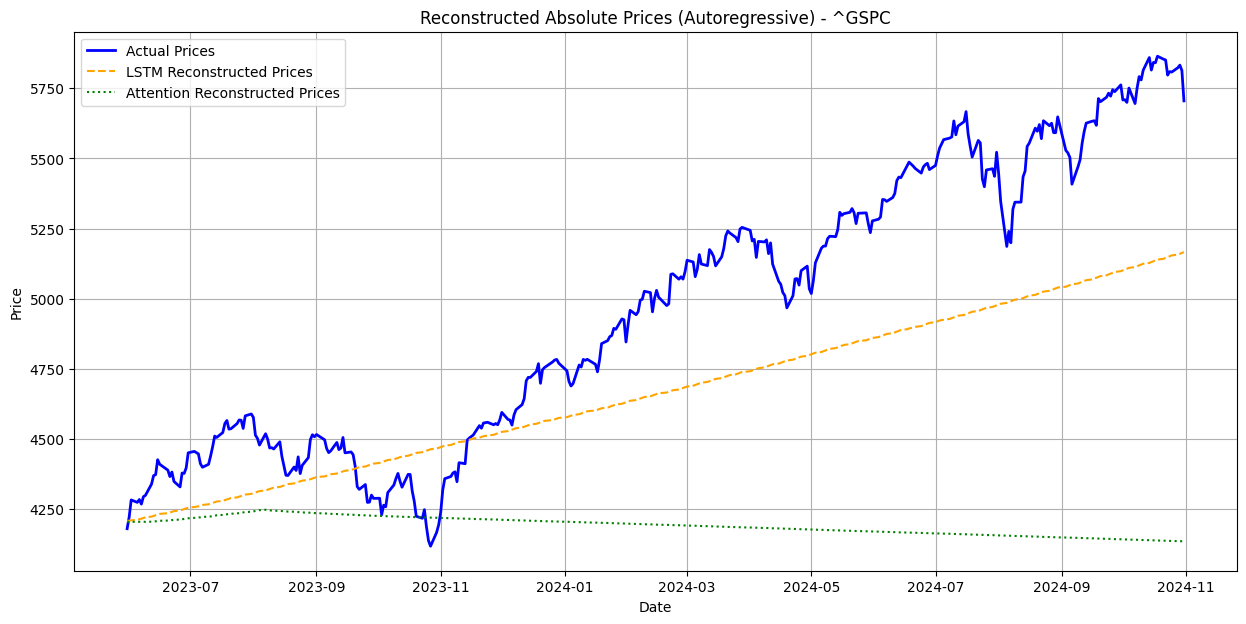

In [14]:
def reconstruct_prices(start_price, log_returns):
    """Converts log returns back to absolute prices."""
    prices = [start_price]
    current_price = start_price
    for log_ret in log_returns:
        current_price = current_price * np.exp(log_ret)
        prices.append(current_price)
    return np.array(prices)

# --- Find the correct start price ---

# Use the pd.Series of unscaled log returns we saved
first_test_log_return_index = log_returns_unscaled_pd.index[split_idx_raw + BASE_WINDOW_SIZE]

# Use the 'Adj Close' column from the original prices_df
prices_orig = prices_df['Adj Close']

start_price_timestamp = prices_orig.index[prices_orig.index < first_test_log_return_index][-1]
start_price = prices_orig.loc[start_price_timestamp].iloc[0]

actual_test_prices_pd = prices_orig.loc[first_test_log_return_index:]


# --- Un-scale the predictions (NEEDS TO HAPPEN FIRST) ---
# We use the mean and scale we saved from the *first feature*
lstm_preds_unscaled = (lstm_preds_autoregressive * log_return_scale) + log_return_mean
attn_preds_unscaled = (attn_preds_autoregressive * log_return_scale) + log_return_mean


# --- NOW we can get the length and slice our data ---
num_preds = len(lstm_preds_unscaled)
actual_test_prices = actual_test_prices_pd.iloc[:num_preds].values

print(f"Reconstruction Start Price (on {start_price_timestamp.date()}): ${start_price:.2f}")
print(f"Actual test prices to compare: {len(actual_test_prices)}")
print(f"Predictions made: {num_preds}")

# --- Reconstruct prices from un-scaled predictions ---
lstm_recon_prices = reconstruct_prices(start_price, lstm_preds_unscaled)
attn_recon_prices = reconstruct_prices(start_price, attn_preds_unscaled)

# --- Plot reconstructed prices ---
plt.figure(figsize=(15, 7))
test_index = actual_test_prices_pd.iloc[:num_preds].index

plt.plot(test_index, actual_test_prices, label='Actual Prices', color='blue', linewidth=2)
plt.plot(test_index, lstm_recon_prices[1:], label='LSTM Reconstructed Prices', color='orange', linestyle='--')
plt.plot(test_index, attn_recon_prices[1:], label='Attention Reconstructed Prices', color='green', linestyle=':')

plt.legend()
plt.title(f'Reconstructed Absolute Prices (Autoregressive) - {STOCK_TICKER}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

## 6. Experimentation with Sliding Window Sizes

Now we'll automate the process to test different window sizes (10, 25, 50, 100). 

**Note:** As per the assignment instructions, we will **only run this for the basic LSTM model** because training the attention model repeatedly is very time-consuming.


==================== RUNNING FOR WINDOW SIZE: 10 ====================
--- Starting Training for models/lstm_model_w10.pth ---
Epoch 001/100 | Train Loss: 1.003565 | Val Loss: 0.445717
   ...Val loss improved to 0.445717. Saving model to models/lstm_model_w10.pth...
Epoch 002/100 | Train Loss: 1.001611 | Val Loss: 0.444298
   ...Val loss improved to 0.444298. Saving model to models/lstm_model_w10.pth...
Epoch 003/100 | Train Loss: 0.998225 | Val Loss: 0.447083
   ...EarlyStopping counter: 1 out of 10
Epoch 004/100 | Train Loss: 0.993545 | Val Loss: 0.447208
   ...EarlyStopping counter: 2 out of 10
Epoch 005/100 | Train Loss: 0.986345 | Val Loss: 0.446142
   ...EarlyStopping counter: 3 out of 10
Epoch 006/100 | Train Loss: 0.981958 | Val Loss: 0.443124
   ...Val loss improved to 0.443124. Saving model to models/lstm_model_w10.pth...
Epoch 007/100 | Train Loss: 0.990684 | Val Loss: 0.443659
   ...EarlyStopping counter: 1 out of 10
Epoch 008/100 | Train Loss: 0.966868 | Val Loss: 0.444700

,MSE,RMSE,MAE
window_size,,,
10,0.440767,0.663903,0.507008
25,0.452157,0.672426,0.515384
50,0.441292,0.664298,0.509650
100,0.463366,0.680710,0.516311


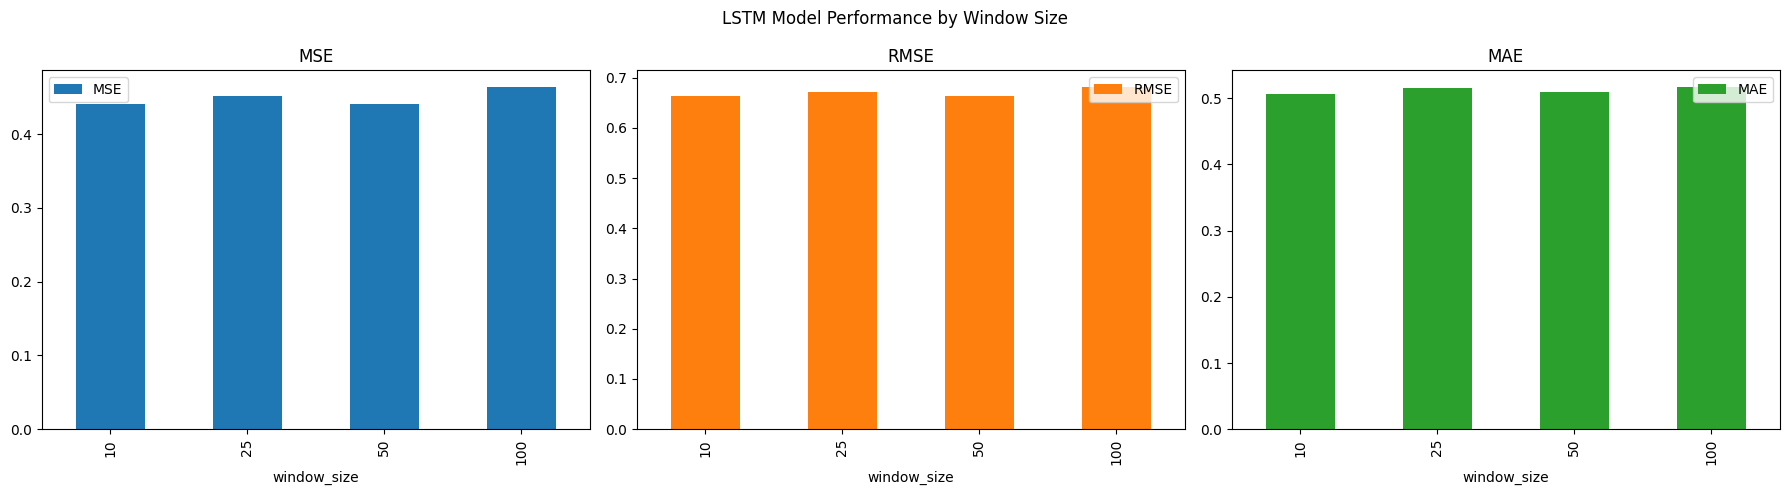

In [15]:
def run_window_experiment(window_size, full_features_np):
    """A complete pipeline to train and evaluate an LSTM model for a given window size."""
    print(f"\n{'='*20} RUNNING FOR WINDOW SIZE: {window_size} {'='*20}")
    
    # 1. Data Prep 
    
    # Split
    split_idx = int(len(full_features_np) * TRAIN_SPLIT)
    train_raw = full_features_np[:split_idx]
    test_raw = full_features_np[split_idx:]
    
    # Scale
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train_raw)
    test_scaled = scaler.transform(test_raw)
    
    # Create windows
    X_train, y_train = create_sliding_windows(train_scaled, window_size)
    X_test, y_test = create_sliding_windows(test_scaled, window_size)
    
    if len(X_test) == 0:
        print("Test set is empty. Skipping.")
        return None
    
    # Reshape
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)
    
    # Tensors
    X_train_t = torch.tensor(X_train).float()
    y_train_t = torch.tensor(y_train).float()
    X_test_t = torch.tensor(X_test).float()
    y_test_t = torch.tensor(y_test).float()
    
    # DataLoaders
    train_dataset = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_dataset = TensorDataset(X_test_t, y_test_t)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # 2. Model Training
    model = LSTMModel(
        input_size=2, 
        hidden_size=HIDDEN_SIZE,
        num_layers=NUM_LAYERS,
        dropout=DROPOUT
    ).to(DEVICE)
    
    model, _, _ = train_model(
        model,
        train_loader,
        test_loader,
        EPOCHS,
        LEARNING_RATE, 
        PATIENCE,
        f'models/lstm_model_w{window_size}.pth'
    )
    
    # 3. One-Step-Ahead Evaluation 
    preds = get_one_step_ahead_predictions(model, test_loader)
    actuals = y_test_t.cpu().numpy().flatten()
    
    # 4. Calculate Metrics
    metrics = calculate_metrics(preds, actuals)
    metrics['window_size'] = window_size
    
    print(f"--- Metrics for window {window_size}: {metrics} ---")
    return metrics

# --- Run the Experiments ---
window_sizes = [10, 25, 50, 100]
experiment_results = []

# Pass the main 2-feature features_np array
for ws in window_sizes:
    result = run_window_experiment(ws, features_np) 
    if result:
        experiment_results.append(result)

# --- Compare Results ---
print("\n\n{'='*20} FINAL WINDOW SIZE COMPARISON {'='*20}")
results_df = pd.DataFrame(experiment_results).set_index('window_size')
display(results_df)

# Plot the results
results_df.plot(kind='bar', subplots=True, layout=(1, 3), figsize=(18, 5), title="LSTM Model Performance by Window Size")
plt.tight_layout()
plt.show()

# Discussion